# HuggingFace Fune Tune ViT MAE Blog

https://huggingface.co/blog/fine-tune-vit

Another similar one: https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb

In [1]:
# Installing Needed Packages

!pip install datasets transformers

# Loading Dataset

In [2]:
from datasets import load_dataset

ds = load_dataset('beans')
ds


/usr/local/lib/python3.8/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

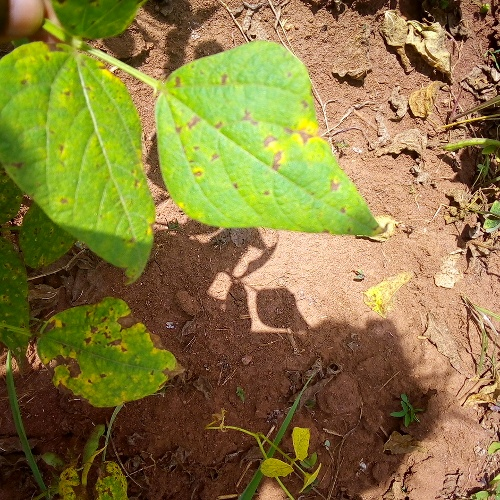

In [3]:
image = ds['train'][0]['image']
image

In [4]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

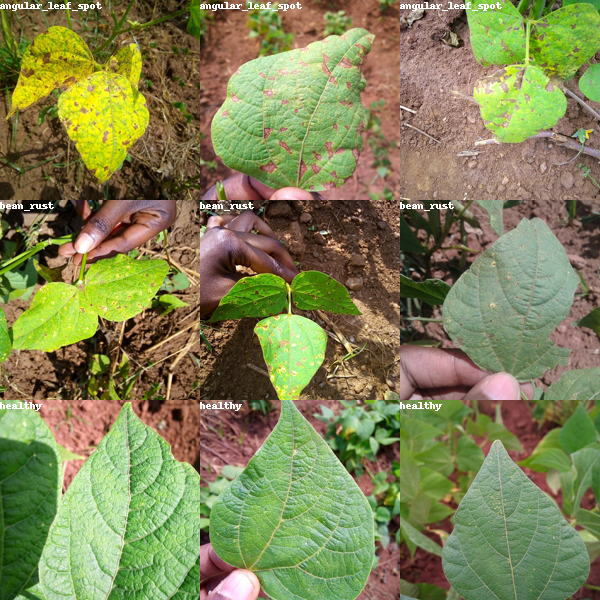

In [5]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(200, 200)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    # font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24) # Causing an error

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            # draw.text(box, label, (255, 255, 255), font=font)
            draw.text(box, label, (255, 255, 255))

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)


# Feature Extractor

In [6]:
from transformers import ViTFeatureExtractor

model_name_or_path = "facebook/vit-mae-base"
'''
From: https://huggingface.co/google/vit-base-patch16-224-in21k
'''
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

2023-09-06 19:23:37.752588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/projects/Cervical_Cancer_Projects/transformers/src/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
'''
From: https://huggingface.co/google/vit-base-patch16-224-in21k
'''
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
feat_extracted_image = feature_extractor(image, return_tensors='pt')
print(feat_extracted_image)
print(feat_extracted_image['pixel_values'].shape)

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

# Preprocessing

In [9]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [10]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

In [11]:
# Doing it all at once

ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt') # The same as above, but for everything in the batch

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [12]:
prepared_ds = ds.with_transform(transform)

In [13]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

## Collating

In [14]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# Evaluation Metric

In [15]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_224886/2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [16]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training Arguments

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

# Training Loop

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [19]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
100,0.026900,0.015961,1.000000


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1324
  train_runtime            =  0:00:53.80
  train_samples_per_second =      76.868
  train_steps_per_second   =       2.453
